In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

# Adeoti Temiloluwa,303008

##  Data PreProcessing
- wine quality data is read and stored in variable `winred`

In [2]:
winred  = pd.read_csv("winered.csv", delimiter = ";")
win_y = winred["quality"]
win_X = winred.drop(columns = ['quality'])
print(f"Dataset has {len(win_X.columns)} features")

Dataset has 11 features


In [3]:
win_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


- function `standardize_features` standardizes the dataset 
- Function `train_test_split` performs train-test split on a dataset in ration 80:20
- The function is used to generate train-test split for the dataset 

In [4]:
standardize_features = lambda x: (x - x.mean()) / x.std()
normalize_features  = lambda x: (x - x.min()) / (x.max() - x.min())

def train_test_split(x_data,y_data):
    np.random.seed(5)
    a = np.arange(len(x_data))
    np.random.shuffle(a)
    split = int(len(x_data)*0.7)
    X_train, X_test, y_train, y_test = x_data.iloc[a[:split],:],\
                                    x_data.iloc[a[split:],:],\
                                    y_data.iloc[a[:split]],\
                                    y_data.iloc[a[split:]]
    assert(len(X_train) + len(X_test) == len(x_data))
    assert(len(y_train) + len(y_test) == len(y_data))
    return X_train, X_test, y_train, y_test

win_X = standardize_features(win_X)
Xtrain, Xtest, ytrain, ytest = train_test_split(win_X,win_y)

print(f"Shape of Xtrain : {Xtrain.shape}")
print(f"Shape of Xtest  : {Xtest.shape}")
print(f"Shape of ytrain : {ytrain.shape}")
print(f"Shape of Xtest  : {ytest.shape}")

if type(Xtrain) == type(winred):
    Xtrain = Xtrain.values
    Xtest  = Xtest.values
    ytrain = ytrain.values
    ytest  = ytest.values

Shape of Xtrain : (1119, 11)
Shape of Xtest  : (480, 11)
Shape of ytrain : (1119,)
Shape of Xtest  : (480,)


## Q1 K-Nearest Neighbors

### Description of Class KNN methods and attributes
#### Private Attributes
- Class KNN is intialized with `k`, the number of neighbors.
- `_k_neighbors` is the most important attribute in the class
    - It stores the k nearest neighbors as a tuple of the neighbors index and euclidean distance to the query datapoint
    - It is of length `k`
    - The tuples are stored in it in **DESCENDING ORDER** of distances, **HIGHEST to LOWEST**
    - All the `_k_neighbors` for all the test set examples are stored in `_test_set_neighbors`
    - for example, if k = 5, `_k_neighbors` for the first test set example is:
    ```python     
    [(860, 1.9474045543875391),(1018, 1.941104967896153),(127, 1.9016909517227305),
         (602, 1.7989084072574815),(945, 1.4307068001798398)]
    ```

#### Methods
- **_euclid_dist**: calculates the euclidean distance between two vectors
- **validate_neighbors**: This is just a function that validates that  `self._k_neighbors` was sorted properly in descending order
- **_append_into_k_neighbors**:Called by `fit method` when the size of `self._k_neighbors` is less than or equal to `self._k` and appends neighbor information to `self_.k_neighbors`
- ** _insert_into_k_neighbors**: Called by `fit method`when the size of `self._k_neighbors` is greater than `self._k` and inserts neighbor information to `self_.k_neighbors`
    - If new neighbor is found, it enters `self._k_neighbors` and `element(0)`, highest distance ,is popped
- **fit**: Function that performs the training stage
- **predict_regression**: Returns regression predictions
-**rmse**: Calculates RMSE
- **predict_classification** - Returns classification predictions
- **accuracy** - Calculates Accuracy
- **display_neighbors** - produces a dataframe displaying all the neighbors with distance information

### The Fit Method
*For each test example, which is the query point, the following is performed by the fit method*:
1. For each  train set example the euclidean distance to the query test set is calculated 
2. For the first set of k examples in the trainset, `_append_into_k_neighbors` appends their `(index,distance)` tuple to `_k_neighbors`
3. Once `_k_neighbors` is of length `k`, it is sorted in descending order of distances by `_append_into_k_neighbors`
4. Any new train set example, whose euclidean distance is calculated `X_train[k:]` will be inserted into `_k_neighbors` if it's distance is less than any of the current neighbors by `_insert_into_k_neighbors`
5. `_insert_into_k_neighbors` also pops out element 0, the one with highest distance, after insertion
6. After all the distances are calculated, the neighbors are appended to `._test_set_neighbors`
7. Finally, `validate_neighbors` picks 20 random sets of neighbors in `_test_set_neighbors` to ensure that they are arranged in order of decreasing euclidean distances




In [16]:
class KNN():
    def __init__(self,k):
        #number of neighbors
        self._k = k 
        #store k nearest neighbors and distances for a single query object
        self._k_neighbors = []
        #store neighbors and distances for all query objects
        self._test_set_neighbors = []
        
    #calculates euclidean distances between two vectors
    def _euclid_dist(self,vector_a,vector_b):
        return np.sqrt(np.sum((vector_a- vector_b)**2))
    
    #validates that  _k_neighbors was sorted in descending order for a random number of queries
    def validate_neighbors(self):
        random_indices = np.random.randint(0,len(self._test_set_neighbors),20)
        for i in random_indices:
            data = self._test_set_neighbors[i]
            for j in range(len(data) - 1) :
                index,dist            = data[j]
                next_index,next_dist  = data[j+1]
                
                try:
                    assert(dist >= next_dist)
                except AssertionError:
                    print(f"index {index},dist{dist}")
                    print(f"next index {next_index},next dist{next_dist}")

    #Called when the size of self._k_neighbors is less than or equals self._k and appends neighbor information to self_.k_neighbors
    def _append_into_k_neighbors(self,new_neighbor_index, new_neighbor_dist):
        new_neighbor = (new_neighbor_index, new_neighbor_dist)
        self._k_neighbors.append(new_neighbor)
        
        if len(self._k_neighbors) == self._k:
            self._k_neighbors.sort(reverse = True, key = lambda tup: tup[1])
        return 
            
    #Called when the size of self._k_neighbors is greater than self._k and inserts neighbor information to self_.k_neighbors
    #If new neighbor is found, it enters self._k_neighbors and element(0), highest distance is popped
    def _insert_into_k_neighbors(self,new_neighbor_index, new_neighbor_dist):
        new_neighbor        = (new_neighbor_index, new_neighbor_dist)
        insertion_pointer   = 0
      
        for index,dist in self._k_neighbors:
            len_of_neighbors = len(self._k_neighbors)
            
            if new_neighbor_dist < dist:
                insertion_pointer += 1
            else: 
                self._k_neighbors.insert(insertion_pointer,new_neighbor)
                self._k_neighbors.pop(0)
                break
            
            #will only occur if the newentry is has a distance smaller than all others  
            if insertion_pointer == len_of_neighbors:
                self._k_neighbors.insert(insertion_pointer,new_neighbor)
                self._k_neighbors.pop(0)
        insertion_pointer   = 0
        
        return
    
    #train the model
    def fit(self,X_train,X_test):
        len_test  = len(X_test)
        len_train = len(X_train)
        
        for query_index in range(len_test):
            query = X_test[query_index]
            for train_index in range(len_train):
                train_dist = self._euclid_dist(query,X_train[train_index])
                if train_index < self._k:
                    self._append_into_k_neighbors(train_index,train_dist)
                else:
                    self._insert_into_k_neighbors(train_index,train_dist)
            
            #store neighbors information in self._test_set_neighbors of current test query
            self._test_set_neighbors.append(self._k_neighbors)
            #delete all entries in _k_neigbors for the next query
            self._k_neighbors = []
        self.validate_neighbors()
        return 
        
    def predict_regression(self,y_train):
        num_queries        = len(self._test_set_neighbors)
        prediction_queries = np.empty((num_queries,1))
        for i in range(num_queries):
            prediction = 0
            for index, _ in self._test_set_neighbors[i]:
                prediction += y_train[index]
            prediction_queries[i] = prediction/self._k
        
        return prediction_queries
    
    def rmse(self,y_train,y_test):
        error = y_test - self.predict_regression(y_train)
        return np.sqrt(np.mean(error**2))
    
    def predict_classification(self,y_train):
        num_queries        = len(self._test_set_neighbors)
        prediction_queries = np.empty((num_queries,1))
        most_common_class  = []
        
        for i in range(num_queries):
            prediction = []
            for index, _ in self._test_set_neighbors[i]:
                prediction.append(y_train[index])
            count = Counter(prediction)
            most_common_class.append(count)
            prediction_queries[i] = count.most_common(1)[0][0]
        return prediction_queries,most_common_class
    
    def accuracy(self,y_train,y_test):
        return np.mean(y_test == self.predict_classification(y_train)[0]) * 100
    
    def display_neighbors(self):
        cols = []
        for i in range(self._k):
            cols.append('Neighbor '+str(i)+' (index,distance)')
        neighbor_dataframe = pd.DataFrame(self._test_set_neighbors)
        neighbor_dataframe.columns = cols

        return neighbor_dataframe
    
    

In [6]:
k = 5
model = KNN(5)
model.fit(Xtrain,Xtest)
model.display_neighbors().head(5)

,"Neighbor 0 (index,distance)","Neighbor 1 (index,distance)","Neighbor 2 (index,distance)","Neighbor 3 (index,distance)","Neighbor 4 (index,distance)"
0,"(860, 1.9474045543875391)","(1018, 1.9411049678961516)","(127, 1.9016909517227278)","(602, 1.7989084072574801)","(945, 1.4307068001798398)"
1,"(749, 1.4748968508229383)","(339, 1.4396812826573524)","(954, 1.4019596131091547)","(360, 1.2276205010144727)","(496, 1.1770751088692828)"
2,"(271, 1.1196860488890914)","(753, 1.0812100202201096)","(1043, 1.0560983181664012)","(564, 0.8815926854782233)","(803, 0.7698015501729215)"
3,"(90, 1.7541658026388087)","(496, 1.7524333504764293)","(555, 1.7006135062048342)","(214, 1.7006135062048342)","(374, 1.516091865911077)"
4,"(684, 1.414556139678054)","(393, 1.358576495234689)","(591, 1.2124570020538488)","(571, 1.2124570020538488)","(753, 1.0596875733250466)"


In [7]:
model._test_set_neighbors[0]

[(860, 1.9474045543875391),
 (1018, 1.9411049678961516),
 (127, 1.9016909517227278),
 (602, 1.7989084072574801),
 (945, 1.4307068001798398)]

In [8]:
print(f"Model Accuracy {model.accuracy(ytrain,ytest)}%")
print(f"Model Test RMSE {model.rmse(ytrain,ytest)}")

Model Accuracy 37.416666666666664%
Model Test RMSE 0.9697132308058914


## Quality Criterion choice

### Challenge of the Accuracy Criterion in Classificadtion
- The algorithm states than the majority class should be chosen during classification
- The list below contains Counters that were used to determine the class each data point in the test set belongs to
- Looking at the last element in the list displayed (Counter for test set example 13):
    - One neighbor has a class of 4 
    - Two neighbors have a class of 5
    - Two other neighbos have a class of 6 !
    - ** Should the Class of Data point 13 in the test set be 5 or 6? **
    - **In Summary, the Class with the highest probability is usually not always unique**
    
### Challenge of the RMSE Criterion in Regression
- While Regressing, the mean of all the target values of the neighbors are used.
- The lowest RMSE occurs in this dataset occurs when k = `len(Xtrain)`, the length of the training set
- **This is equivalent to creating a model that is simply prediction = np.mean(ytrain) - Just taking the mean of all the training examples is the prediction for all the trainset examples**.
    - This results in a very naive model
  


**Therefore, the Accuracy Criterion will be used**


In [9]:
model.predict_classification(ytrain)[1][:13]

[Counter({5: 1, 6: 4}),
 Counter({5: 2, 6: 2, 7: 1}),
 Counter({6: 2, 7: 3}),
 Counter({5: 1, 6: 1, 7: 1, 8: 2}),
 Counter({6: 3, 7: 2}),
 Counter({4: 1, 5: 3, 6: 1}),
 Counter({6: 1, 7: 4}),
 Counter({5: 5}),
 Counter({5: 4, 6: 1}),
 Counter({5: 4, 6: 1}),
 Counter({5: 5}),
 Counter({4: 1, 6: 4}),
 Counter({4: 1, 5: 2, 6: 2})]

## Q2 Optimal K

In [10]:
klist        = [5,10,50,100,150,200,300,350,500, 750, 1000, len(Xtrain)]
print(f"klist {klist}")
k_model_rmse = []
k_model_acc = []
for k in klist:
    model = KNN(k)
    model.fit(Xtrain,Xtest)
    k_model_rmse.append(model.rmse(ytrain,ytest))
    k_model_acc.append(model.accuracy(ytrain,ytest))

klist [5, 10, 50, 100, 150, 200, 300, 350, 500, 750, 1000, 1119]


In [11]:
def plot_k(criterion_list,klist,criterion_type):
    plt.figure(figsize = (8,8))
    plt.plot(criterion_list)
    plt.xticks(np.arange(len(criterion_list)),klist)
    plt.xlabel("K values")
    plt.ylabel(criterion_type)
    plt.title("Plot of "+criterion_type + " vs K")

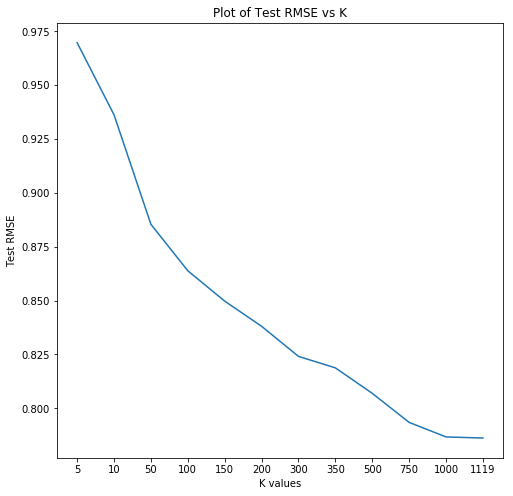

In [12]:
plot_k(k_model_rmse,klist,"Test RMSE")

In [13]:
print(f"Lowest RMSE is {np.min(k_model_rmse)} which occurs when k = {klist[np.argmin(np.array(k_model_rmse))]}")

Lowest RMSE is 0.7861857632720161 which occurs when k = 1119


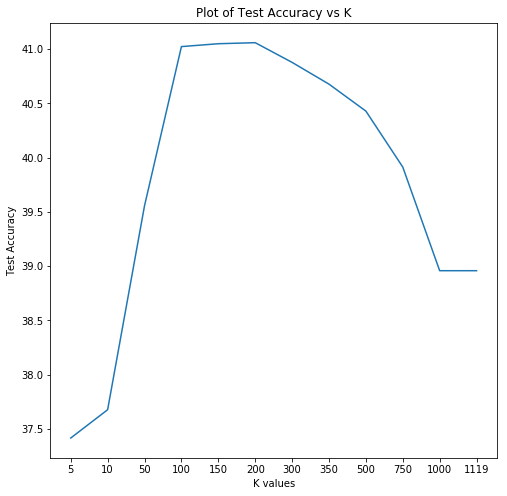

In [14]:
plot_k(k_model_acc,klist,"Test Accuracy")

In [15]:
print(f"Highest Accuracy is {np.max(k_model_acc)}% which occurs when k = {klist[np.argmax(np.array(k_model_acc))]}")

Highest Accuracy is 41.05902777777778% which occurs when k = 200


- The optimal value of K is chosen to be 200 using the accuracy criterion